# Skip-gram Word2Vec

skip-gram architecture 로 Word2Vec을 구현해 보자.


## Word embeddings

단어 임베딩(Word Embedding)이란 텍스트를 구성하는 하나의 단어를 수치화하는 방법의 일종이다.

텍스트에 나타난 단어를 수만개가 될수 있는데 이것을 one-hot encoding 방식으로 처리하는 것은 매우 비효율적이다. 단어를 one-hot vector로 나타내면 대부분 0 값이 된다. hidden layer에서 one-hot input vector와 연산이 대부분 0이 된다. 

이런 비효율성을 개선하기 위한 것이 **embeddings** 이다. Embedding layer는 앞서 본 fully connected layer와 같은 형태이다. embedding layer의 weights를 embedding weights라고 한다. 

![img](../assets/lookup_matrix.png)
matrix multiplication을 수행하는 대신에 weight matrix를 lookup table로 사용한다. words를 integers 로 변환하게 된다. "heart" 단어가 958로 encode 되었다면, 해당 hidden layer values는 그냥 embedding matrix에서 958번째 row 를 가져오면 된다. 이것을 **embedding lookup** 라고 하고 hidden units의 갯수가 **embedding dimension**이 된다.
 
embedding lookup table은 단순한 weight matrix이고 embedding layer는 hidden layer이다. lookup 은 matrix multiplication을 대체하는 것이다. weight matrix를 학습하게 된다.

**Word2Vec** 은 embedding layer를 통해서 word를 벡터로 표현한다.

---
## Word2Vec

Word2Vec algorithm은 단어를 verctor로 표현한다. 또한 vectors는 단어의 semantic information을 포함한다.

![img](../assets/context_drink.png)

단어들의 유사도는 vector space에서 거리로 표현된다. 예를 들어 "coffee", "tea", "water"는 가까운 위치에 있다.

Word2Vec을 구현하는 2가지 방법:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

![img](../assets/word2vec_architectures.png)

**skip-gram architecture** 으로 구현해 보자. CBOW 보다 성능이 우수하다.

**negative sampling**을 사용하면 학습 시간이 더 빨라질수 있다. 중심 단어를 입력하면 텍스트에서 그 단어 주변의 단어를 예측하게 한다. 이러한 학습 과정을 통해 단어의 similar contexts를 표현할 수 있다.

---
## Loading Data

text8 dataset은 *Wikipedia article text* 를 정리한 파일이다. 


In [2]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

제공되는 `utils.py` file의 `preprocess` function 을 사용하여 해당 text를 전처리한다:
>* punctuation 을 tokens으로 만든다. 예를 들면 마침표 부호를 ` <PERIOD> `로 변환한다. 
* 출현 빈도가 5보다 작은 단어는 삭제한다. 
* 텍스트에 있는 단어들을 리스트로 리턴한다.


In [3]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

단어-->숫자, 숫자--> 단어로 변환하는 2개의 딕셔너리를 생성한다. 
 `utils.py` file의 `create_lookup_tables` 함수가 이 2개의 딕셔너리를 생성하여 리턴한다.
>* 단어의 빈도수를 내림차순으로 기준하여 index로 변환한다. 

일단 텍스트의 단어 리스트를 숫자로 변환하여 int_words에 저장한다.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling
 
"the", "of", "for" 같은 단어들은 빈도수가 너무 많지만 의미가 크지는 않다. 이러한 단어를 제거하여 데이터의 노이즈를 제거한다. 이렇게 하면 학습량을 줄여 학습 속도를 높일 수 있다. 이것을 subsampling라고 한다. train set의 word $w_i$ 에 대해서 다음의 확률로 단어를 제거한다. 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

 $t$ 는 threshold parameter로 상수로 지정한다. $f(w_i)$는 전체 단어들 중에서 나타난 단어 $w_i$의 빈도이다.

> `int_words`에 대해서 subsampling을 수행한다.위에서 계산한 $P(w_i)$의 확률로 단어를 제거한다. subsampled된 데이터를 `train_words`에 할당한다.

In [6]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[5233, 3080, 3133, 10571, 27349, 15067, 58112, 150, 854, 3580, 10712, 2731, 362, 3672, 40, 97, 1423, 2757, 567, 7088, 5233, 248, 44611, 792, 5233, 2621, 8983, 4147, 4186, 5233]


## Making batches

전처리된 데이터는 훈련에 알맞은 포맷으로 변형한다. skip-gram architecture에서는 중심단어를 감싸고 있는 단어의 갯수를 window size $C$로 표시한다. 

중심 단어에서 멀리있는 단어는 일반적으로 중심 단어와 관련이 거의 없기 때문에 먼 단어에 대해서는 적은 수의 샘플을 샘플링하여 덜 훈련되도록 한다. 

$C = 5$로 할때 각 training word 는 range $[ 1: C ]$에서 랜덤하게 $R$개를 선택한다. 중심 단어에서 $R$ 개 앞 단어 + $R$ 개 뒤쪽 단어가 최종 선택된다.

> **Exercise:** function `get_target`을 작성하시오. list of words와 index값  window size를 입력받는다. 해당 단어 리스트에서 index단어를 중심으로 window size 만큼의 단어를 출력한다.

예를 들어 다음의 리스트에서 idx=2 일때 741을 중심 단어로 : 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

`R=2`라면 `get_target` 함수는 앞의 2개 뒤의 2개 총 4개의 단어를 리턴한다:
```
[5233, 58, 10571, 27349]
```

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [8]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

input 과 target data 로 batch를 생성한다. 위에서 생성한 `get_target` function 을 사용한다. word list에서 `batch_size` 만큼의 word를 가져온다. 각 batch는 widow size 갯수의 단어를 가져온다.

In [9]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [10]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 2]


---
## Validation

cosine similarity를 사용하여 우리가 선택한 단어와 가장 유사한 단어를 출력한다.


![img](../assets/two_vectors.png)
$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


validation words를  vectors $\vec{a}$ 로 encoding한다. 그리고 validation words 와 embedding table의 단어들에 대한 유사도를 확인한다. 이를 통해 embedding table 내에 학습된 단어들이 얼마나 잘 유사한 단어끼리 grouping 되어 있는지 확인할 수 있다.

In [11]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram model

SkipGram model을 생성한다. 
> [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) 와 마지막의 softmax output layer를 생성한다.

Embedding layer :
* **num_embeddings** – dictionary of embeddings의 크기,또는 embedding weight matrix의 row갯수
* **embedding_dim** – 각 embedding vector의 크기

일반적인 구조.

![img](../assets/skip_gram_arch.png)
>* input words는 input word tokens의 batch 형태로 입력값이다. 
* embedding layer로 전달된다. 
* 마지막으로 softmax output layer. 

마지막 softmax함수는 예측 단어의 확률을 나타낸다.

---
## Negative Sampling

마지막에 softmax함수를 통해 확률이 높은 예측 단어를 계산하는데 총 단어의 수가 매우 많을수록(백만단위) softmax함수의 계산에 시간이 많이 소요되며 훈련에 매우 비효율적이다.

이를 개선한 것이 negative sampling 기법이다.

첫번째, 모든 words에 대해서 softmax함수를 계산하지 않는다. 한번에 하나의 output만을 고려한다. hidden layer를 output word로 map하는 embedding layer를 하나 더 사용한다. 2개의 embedding layers를 사용하여 하나는 input words 를 위한 것이고 나머지 하나는 output words를 위한 것이다.   
두번째, loss function를 다음과 같이 변형한다. 

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

 $u_{w_O}\hspace{0.001em}^\top$ "output" target word 이다. $v_{w_I}$ is the embedding vector "input" word이다. 
 
 
$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

noise는 전체 vocabulary에서 input word의 context에 포함이 안되는 word를 가르키는 것으로 random sampling을 한다. random 샘플링을 할 때 unigram distribution을 사용한다. 
$U(w)^{3/4}$을 사용한다. 

마지막으로, 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

noise vector와 input vector에 대한 부분이다. 


![img](../assets/neg_sampling_loss.png)

sigmoid는 0과 1사이의 확률을 출력한다. correct target부분은 1이 되도록 noisy target 부분은 0이 되도록 훈련이 진행된다. 

In [12]:
import torch
from torch import nn
import torch.optim as optim

In [13]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        # return input vector embeddings
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        # return output vector embeddings
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        ## TODO: get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

In [14]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

### Training

**주의!!!**  
CPU에서 훈련시 오랜 시간이 소요될 수 있다.

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 1

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/2
Loss:  6.9074907302856445
as | the, heaviest, seminars, buddha, hills
for | the, leaders, scandals, arc, readings
see | many, manufacturing, continue, largely, gorda
but | pact, the, fermented, antarctic, exists
they | one, theologians, a, mistress, petroleum
use | overlooked, concerted, become, union, etc
so | shadows, armored, darwinian, contrasts, miller
during | additional, blocks, jalal, ultimate, mainstream
applications | loan, affecting, insurgent, summons, satirical
quite | paulo, cold, buckminster, handles, capitalist
active | strife, communal, disk, readmitted, practised
mathematics | the, narses, ulm, leagues, pressure
writers | corps, prisoners, appearance, nubian, dialects
pope | franz, lynch, crawler, behalf, barber
magazine | rate, views, call, choose, dignified
engine | misquoted, economic, rider, slowly, weeks
...

Epoch: 1/2
Loss:  5.204704761505127
the | and, of, in, a, to
most | and, of, a, more, suspended
up | also, zero, conditions, phases, awkward
thre

In [ ]:
# 훈련된 모형을 저장한다.
       
model_name = 'word2vec.pt'

checkpoint = {'n_vocab': model.n_vocab,
              'n_embed': model.n_embed,
              'noise_dist' : model.noise_dist,
              'state_dict': model.state_dict()
             }

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

### 훈련된 모형을 불러오기

In [15]:
# Here we have loaded in a model that trained over 5 epochs `word2vec_5.pt`
with open('word2vec_5.pt', 'rb') as f:
    checkpoint = torch.load(f, map_location=lambda storage, loc: storage)
    
model = SkipGramNeg(checkpoint['n_vocab'], checkpoint['n_embed'], checkpoint['noise_dist'])

model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

## Visualizing the word vectors

high-dimensional word vectors를 시각화 할 수 있다. T-SNE 를 사용하면 유사한 단어 벡터끼리 클러스터링하여 표시된다. 

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [18]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

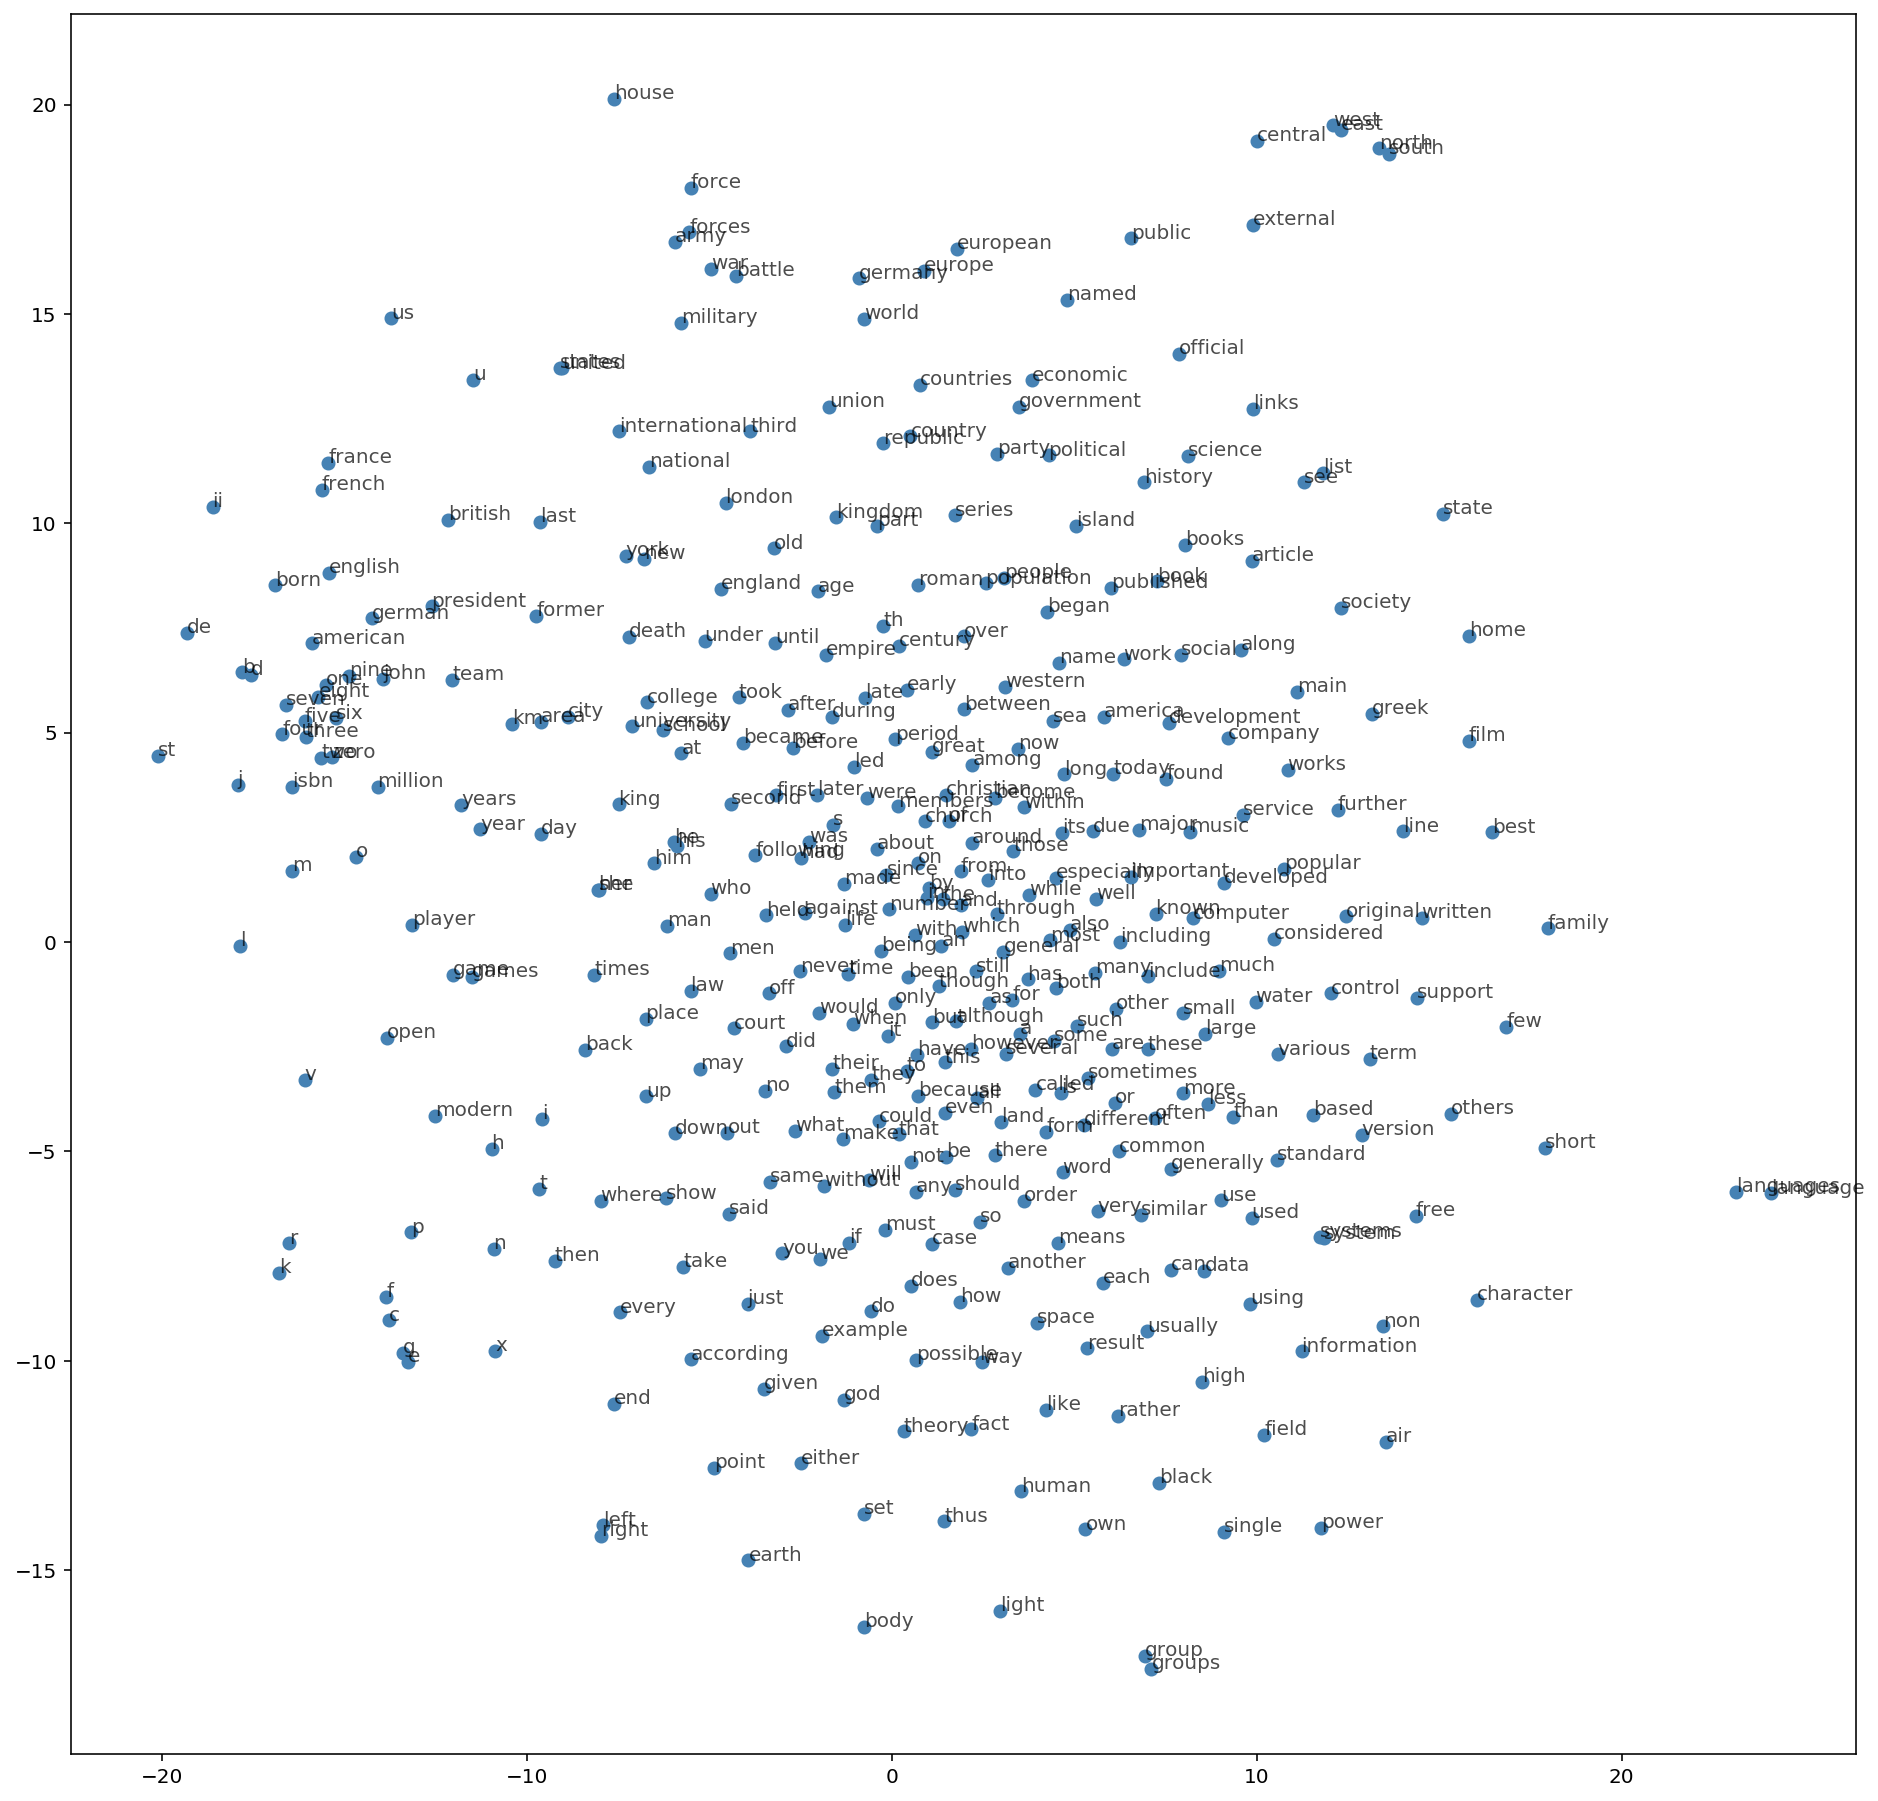

In [19]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)